In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import requests
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [6]:
url = 'http://opsahl.co.uk/tnet/datasets/OF_longitudinal_weightedchar.txt'
r = requests.get(url)

In [7]:
# import string as str
answer = r.text
# print(answer)
print(type(answer))
output = answer.split("\n")

<class 'str'>


In [70]:
data_array = []
for lines in output:
    line = lines.split(' ')
    line[0:2] = [' '.join(line[0:2])]
    data_array.append(line)
data_array

[['"2004-05-14 20:53:16"', '201', '3', '23'],
 ['"2004-05-14 20:54:08"', '187', '3', '63'],
 ['"2004-05-14 20:55:40"', '138', '2', '6'],
 ['"2004-05-14 21:00:04"', '345', '3', '38'],
 ['"2004-05-14 21:02:17"', '233', '3', '60'],
 ['"2004-05-14 21:02:21"', '140', '4', '7'],
 ['"2004-05-14 21:03:35"', '307', '3', '33'],
 ['"2004-05-14 21:06:14"', '352', '3', '12'],
 ['"2004-05-14 21:09:11"', '269', '3', '42'],
 ['"2004-05-14 21:14:15"', '187', '5', '61'],
 ['"2004-05-14 21:14:29"', '269', '5', '75'],
 ['"2004-05-14 21:15:37"', '201', '5', '101'],
 ['"2004-05-14 21:18:57"', '233', '5', '28'],
 ['"2004-05-14 21:39:16"', '281', '3', '11'],
 ['"2004-05-14 21:44:30"', '44', '7', '9'],
 ['"2004-05-14 21:50:12"', '239', '3', '36'],
 ['"2004-05-14 21:55:20"', '239', '5', '102'],
 ['"2004-05-14 21:55:30"', '213', '9', '7'],
 ['"2004-05-14 21:55:52"', '402', '9', '4'],
 ['"2004-05-14 21:56:02"', '402', '9', '33'],
 ['"2004-05-14 21:56:40"', '402', '9', '4'],
 ['"2004-05-14 21:56:47"', '356', '9', 

In [115]:
#Creating an empty dataframe to populate in python
index = np.arange(len(data_array)) #Number of indexes needed
columns = ['datetime', 'person', 'forum', 'unknown']
df = pd.DataFrame(columns=columns, index = index)

#create data frame from array
for val, item in enumerate(data_array):
    df.ix[val] = item

In [10]:
#Test writing to database in cypher language
from py2neo import neo4j, authenticate, Graph, Node, Relationship

# Creates the connection to the graph which defaults to the localhost
# set up authentication parameters
# authenticate("localhost:7474", "user", "pass")

# connect to authenticated graph database
remote_graph = Graph("http://localhost:7474/db/data/")


In [11]:
# Testing writing to the graph 

alice = Node("Person", name="Alice")
bob = Node("Person", name="Bob")
alice_knows_bob = Relationship(alice, "KNOWS", bob)
remote_graph.create(alice_knows_bob)

(<Relationship graph='http://localhost:7474/db/data/' ref='relationship/0' start='node/0' end='node/1' type='KNOWS' properties={}>,)

In [113]:
# The below line deletes any existing data in the neo4j database
remote_graph.cypher.execute("MATCH (n) OPTIONAL MATCH (n)-[r]-() DELETE n,r") # deleting existing data

In [28]:
data_array.pop()#removing last element of list (NEED TO FIX THIS LATER)

[]

In [123]:
# Try inputting all the user nodes as one type and forum as another
tx = remote_graph.cypher.begin()
# statement = "CREATE  (A:Person {time: {B}})" #Cypher statement to create node
# statement_pers = "CREATE  (A:Person)" #Cypher statement to create node
# statement_forum = "CREATE  (B:Forum)" #Cypher statement to create node
# statement_times = "CREATE (A:Person {pers_id: {E}})-[:COMMENT {date:{C}, time:{D}}]->(B:Forum {for_id: {F}})"
statement_times = "MERGE (A:Person {pers_id: {E}}) MERGE (B:Forum {for_id: {F}}) MERGE (A)-[:COMMENT {date:{C}, time:{D}}]->(B)"


i=0; #This will be our counter for when to commit
j=0; #This will be our counter for lines commited
for lines in data_array:
#date_a, time_a, person_A, forum_a, unknown_a

#Need to merge on the person node - if the person exists then will create
#Need to merge on the forum node and create it if not
#Need to match the full pattern



    tx.append(statement_times, {"A": lines[2], "B": lines[3], "C": lines[0], "D": lines[1], "E": lines[2],"F": lines[3]})
#     mynode = list(remote_graph.find('Forum', property_key=lines[3]))
#     if (len(mynode)==0):
#        tx.append(statement_forum, {"B": lines[3]}) 
    i += 1
    j += 1
    if(i==100):
        tx.commit()
        print (j, ' lines processed')
        i=0
        tx = remote_graph.cypher.begin()
    if(j==10000):
        break
tx.commit() #submit remainder of the lines
print (j, ' lines processed')





100  lines processed
200  lines processed
300  lines processed
400  lines processed
500  lines processed
600  lines processed
700  lines processed
800  lines processed
900  lines processed
1000  lines processed
1100  lines processed
1200  lines processed
1300  lines processed
1400  lines processed
1500  lines processed
1600  lines processed
1700  lines processed
1800  lines processed
1900  lines processed
2000  lines processed
2100  lines processed
2200  lines processed
2300  lines processed
2400  lines processed
2500  lines processed
2600  lines processed
2700  lines processed
2800  lines processed
2900  lines processed
3000  lines processed
3100  lines processed
3200  lines processed
3300  lines processed
3400  lines processed
3500  lines processed
3600  lines processed
3700  lines processed
3800  lines processed
3900  lines processed
4000  lines processed
4100  lines processed
4200  lines processed
4300  lines processed
4400  lines processed
4500  lines processed
4600  lines process

In [29]:
data_array[-10:]

[['"2004-10-25', '23:40:08"', '137', '244', '62'],
 ['"2004-10-25', '23:43:32"', '137', '39', '19'],
 ['"2004-10-25', '23:52:16"', '441', '488', '8'],
 ['"2004-10-26', '00:14:08"', '109', '59', '75'],
 ['"2004-10-26', '01:40:43"', '836', '39', '21'],
 ['"2004-10-26', '01:51:33"', '719', '20', '143'],
 ['"2004-10-26', '01:58:17"', '719', '107', '231'],
 ['"2004-10-26', '02:35:18"', '625', '59', '51'],
 ['"2004-10-26', '08:40:22"', '375', '266', '28'],
 ['"2004-10-26', '08:41:41"', '375', '266', '19']]

In [46]:
data_array[1:2]

[['"2004-05-14', '20:54:08"', '187', '3', '63']]

Now I am going to read in the output from the machine learning model in python and view it

In [86]:
import csv
input = []
f = open("output_scores.csv")
for row in f:
    input.append(row)
    
print (input[1:10])
    

['0,45,0,2.0,2,0.1,0\n', '1,40,0,1.0,0,0.1,0\n', '2,38,0,0.0,1,0.45121951219512196,1\n', '3,30,0,0.0,0,0.02702702702702703,0\n', '4,49,0,0.0,1,0.02702702702702703,0\n', '5,74,0,1.0,0,0.1,0\n', '7,39,0,0.0,0,0.1,0\n', '9,57,0,2.0,0,0.1,0\n', '10,30,0,0.0,0,0.1,0\n']


In [87]:
data_results = pd.read_csv("output_scores.csv", sep=',')

In [88]:
data_results.head()

,Unnamed: 0,age,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberOfTime30-59DaysPastDueNotWorse,prob_class_1,NumberOfTimes90DaysLate
0,0,45,0,2,2,0.100000,0
1,1,40,0,1,0,0.100000,0
2,2,38,0,0,1,0.451220,1
3,3,30,0,0,0,0.027027,0
4,4,49,0,0,1,0.027027,0


In [90]:
data_results[['prob_class_1']].head()

,prob_class_1
0,0.100000
1,0.100000
2,0.451220
3,0.027027
4,0.027027


<class 'numpy.ndarray'>


(array([ 48274.,  39514.,      0.,      0.,   2388.,      0.,   3670.,
             0.,    831.,   1766.]),
 array([ 0.02702703,  0.08932432,  0.15162162,  0.21391892,  0.27621622,
         0.33851351,  0.40081081,  0.46310811,  0.52540541,  0.5877027 ,
         0.65      ]),
 <a list of 10 Patch objects>)

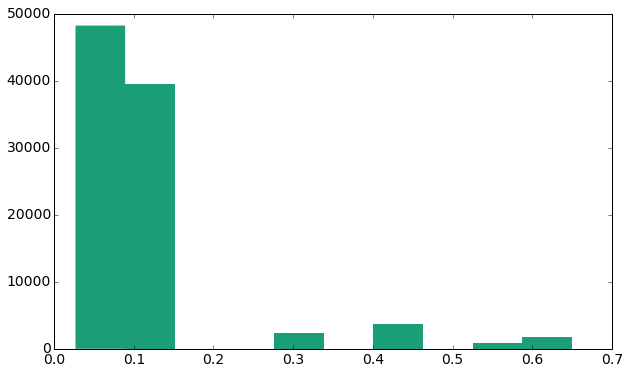

In [107]:
import matplotlib.pyplot as plt

print(type(data_results[['prob_class_1']].as_matrix()))
plt.hist(data_results[['prob_class_1']].as_matrix())

(array([ 215.,  165.,    0.,    0.,    8.,    0.,   16.,    0.,    3.,   10.]),
 array([ 0.02702703,  0.08932432,  0.15162162,  0.21391892,  0.27621622,
         0.33851351,  0.40081081,  0.46310811,  0.52540541,  0.5877027 ,
         0.65      ]),
 <a list of 10 Patch objects>)

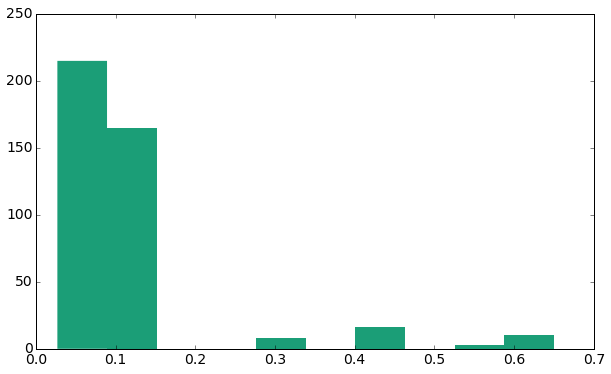

In [110]:
plt.hist(data_results[['prob_class_1']][1:418].as_matrix())

As a 1st test case we have 418 unique person nodes in the first 10,000 lines of our graph file - therefore we will match these to the 1st 418 lines of the risk framework file

In [124]:
# get the first 418 unique values from our graph file
to_merge = pd.unique(df.person.ravel())[0:418] #These are the values we need to add as a column in the data_results data_frame

data_results_mini = data_results[0:418] #Shrink data_results to correct size
data_results_mini['fraud_prob'] = to_merge #Add an extra column which is the probability of fraud
data_results_mini

/Users/Fraser/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unnamed: 0,age,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberOfTime30-59DaysPastDueNotWorse,prob_class_1,NumberOfTimes90DaysLate,fraud_prob
0,0,45,0,2,2,0.100000,0,201
1,1,40,0,1,0,0.100000,0,187
2,2,38,0,0,1,0.451220,1,138
3,3,30,0,0,0,0.027027,0,345
4,4,49,0,0,1,0.027027,0,233
5,5,74,0,1,0,0.100000,0,140
6,7,39,0,0,0,0.100000,0,307
7,9,57,0,2,0,0.100000,0,352
8,10,30,0,0,0,0.100000,0,269
9,11,51,0,2,0,0.650000,0,281


In [129]:
#Here we want to write the fraud probability data to the Neo4j database 
   
tx = remote_graph.cypher.begin()
statement_fraud = "MATCH (n:Person) WHERE n.pers_id = {A} SET n.prob_fraud = {B}"

i=0; #This will be our counter for when to commit
j=0; #This will be our counter for lines commited

for index, row in data_results_mini.iterrows():
#  8 - This column contains the mapping to the nodes in the database
#  6 - This column contains the probability of being fraudulent

    tx.append(statement_fraud, {"A": row[7], "B": row[5]})
    i += 1
    j += 1
    if(i==100):
        tx.commit()
        print (j, ' lines processed')
        i=0
        tx = remote_graph.cypher.begin()
    if(j==10000):
        break
tx.commit() #submit remainder of the lines
print (j, ' lines processed')
    
    

201 0.1
187 0.1
138 0.451219512195122
345 0.027027027027027032
233 0.027027027027027032
140 0.1
307 0.1
352 0.1
269 0.1
281 0.65
44 0.027027027027027032
239 0.1
213 0.027027027027027032
402 0.1
356 0.027027027027027032
216 0.1
18 0.027027027027027032
145 0.027027027027027032
162 0.027027027027027032
106 0.1
230 0.027027027027027032
510 0.1
133 0.027027027027027032
47 0.027027027027027032
421 0.027027027027027032
365 0.027027027027027032
303 0.027027027027027032
23 0.027027027027027032
419 0.027027027027027032
13 0.1
517 0.027027027027027032
241 0.027027027027027032
169 0.027027027027027032
290 0.1
422 0.1
455 0.027027027027027032
122 0.1
73 0.027027027027027032
146 0.1
124 0.43333333333333335
351 0.3333333333333333
205 0.1
511 0.027027027027027032
482 0.027027027027027032
454 0.027027027027027032
12 0.1
306 0.027027027027027032
449 0.027027027027027032
335 0.027027027027027032
264 0.1
408 0.027027027027027032
105 0.027027027027027032
87 0.027027027027027032
403 0.4166666666666667
461 0